# 04 – Trening modelu

Trening klasyfikatorów na embeddingach (LR, SVM, RF, XGBoost). Ewaluacja: accuracy, F1 macro, confusion matrix, wMAE (AR score). Zapis najlepszego modelu.

## 1. Ścieżka projektu i ładowanie embeddingów

In [4]:
import sys
from pathlib import Path

root = Path.cwd()
if not (root / "src").is_dir():
    root = root.parent
sys.path.insert(0, str(root))

import numpy as np
import pandas as pd

processed_dir = root / "data" / "processed"
X_train = np.load(processed_dir / "X_train.npy")
y_train = np.load(processed_dir / "y_train.npy")
X_val = np.load(processed_dir / "X_val.npy")
y_val = np.load(processed_dir / "y_val.npy")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val:", X_val.shape, "| y_val:", y_val.shape)

X_train: (9577, 384) | y_train: (9577,)
X_val: (1002, 384) | y_val: (1002,)


## 2. Metryka wMAE (AR score) – Allegro Reviews

In [5]:
from sklearn.metrics import mean_absolute_error

def ar_score(y_true, y_pred):
    """KLEJ Allegro Reviews: 1 - wMAE (skala 0-1). Wartość w [0, 1], wyższa = lepsza."""
    y_true = (np.asarray(y_true) - 1.0) / 4.0
    y_pred = (np.asarray(y_pred) - 1.0) / 4.0
    wmae = 0.0
    for val in np.unique(y_true):
        mask = y_true == val
        wmae += mean_absolute_error(y_true[mask], y_pred[mask])
    wmae /= len(np.unique(y_true))
    return 1.0 - wmae

## 3. Trening wielu klasyfikatorów

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "SVC": SVC(class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
}
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
except Exception as e:
    print("XGBoost pominięty (np. brak libomp na macOS: uruchom brew install libomp):", type(e).__name__)
    print("  Trening: LR, SVC, RandomForest.")

# XGBoost wymaga etykiet 0–4; dla spójności wszyscy trenują na 0–4, metryki na 1–5
y_train_01 = y_train - 1

results = []
trained = {}

for name, clf in models.items():
    clf.fit(X_train, y_train_01)
    y_pred_01 = clf.predict(X_val)
    y_pred = y_pred_01 + 1  # z powrotem 1–5 do metryk i ar_score
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro")
    ar = ar_score(y_val, y_pred)
    results.append({"model": name, "accuracy": acc, "f1_macro": f1, "ar_score": ar})
    trained[name] = clf
    print(f"{name}: accuracy={acc:.4f}, F1_macro={f1:.4f}, AR_score={ar:.4f}")

LogisticRegression: accuracy=0.5000, F1_macro=0.4439, AR_score=0.7959
SVC: accuracy=0.4810, F1_macro=0.4239, AR_score=0.7942
RandomForest: accuracy=0.4531, F1_macro=0.2717, AR_score=0.6672


/Users/jakub/sentiment-classifier-pl/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: accuracy=0.4860, F1_macro=0.3620, AR_score=0.7393


## 4. Porównanie i wybór najlepszego modelu

In [7]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("f1_macro", ascending=False)
display(results_df)

best_name = results_df.iloc[0]["model"]
best_model = trained[best_name]
print(f"\nNajlepszy (F1 macro): {best_name}")

,model,accuracy,f1_macro,ar_score
0,LogisticRegression,0.500000,0.443875,0.795873
1,SVC,0.481038,0.423926,0.794219
3,XGBoost,0.486028,0.362010,0.739306
2,RandomForest,0.453094,0.271670,0.667198



Najlepszy (F1 macro): LogisticRegression


## 5. Confusion matrix i raport dla najlepszego

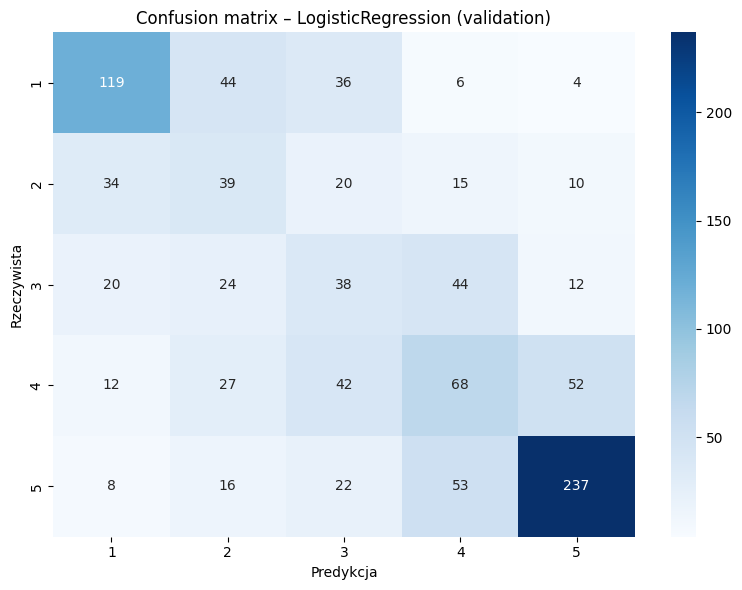

              precision    recall  f1-score   support

           1       0.62      0.57      0.59       209
           2       0.26      0.33      0.29       118
           3       0.24      0.28      0.26       138
           4       0.37      0.34      0.35       201
           5       0.75      0.71      0.73       336

    accuracy                           0.50      1002
   macro avg       0.45      0.44      0.44      1002
weighted avg       0.52      0.50      0.51      1002



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_best = best_model.predict(X_val) + 1  # modele zwracają 0–4, metryki w 1–5
cm = confusion_matrix(y_val, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
ax.set_xlabel("Predykcja")
ax.set_ylabel("Rzeczywista")
ax.set_title(f"Confusion matrix – {best_name} (validation)")
plt.tight_layout()
plt.show()

print(classification_report(y_val, y_pred_best, target_names=["1", "2", "3", "4", "5"]))

## 6. Zapis modelu i metryk

In [9]:
import json
import joblib

models_dir = root / "models"
results_dir = root / "results"
models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, models_dir / "best_classifier.pkl")
print(f"Zapisano model: {models_dir / 'best_classifier.pkl'}")

metrics = {
    "best_model": best_name,
    "validation": results_df[results_df["model"] == best_name].iloc[0].to_dict(),
    "all_models": results,
}
with open(results_dir / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print(f"Zapisano metryki: {results_dir / 'metrics.json'}")

Zapisano model: /Users/jakub/sentiment-classifier-pl/models/best_classifier.pkl
Zapisano metryki: /Users/jakub/sentiment-classifier-pl/results/metrics.json
